In [1]:
%matplotlib inline
from IPython.display import display
from Bio import SeqIO
import pandas as pd
import itertools
from sklearn import preprocessing
from collections import defaultdict
from matplotlib import cm as cm
from sklearn.metrics import classification_report, accuracy_score, make_scorer, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, label_binarize, StandardScaler
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LogisticRegression, RandomizedLasso
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from imblearn.datasets import make_imbalance

import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

## Create dataframe
The dataframe will hold all the data, which will be trained later on.

In [2]:
sequence_data = pd.DataFrame()
subcellular_locations = ['secreted', 'cyto','mito', 'nucleus']

## Add Secreted data to dataframe
This section will add the secreted subcellular location to the dataframe, as well as the id and sequence length of each sequence.

In [3]:
def getAminoAcidComp(analysed_seq):
    count_amino_acids = analysed_seq.count_amino_acids()
    
    summed = 0.0
    for amino_acid, count in count_amino_acids.iteritems():
        if count > 0:
            summed += 1.0
    totalPercentage = summed/len(count_amino_acids)
    return totalPercentage

In [162]:
# Test window
for seq_record in SeqIO.parse("./data/secreted.fasta", "fasta"):
    seq_id = seq_record.id
    seq_rep = str(seq_record.seq)
    seq_len = len(seq_record)
    
    lhs, rhs = seq_id.split("_", 1)
    
    print seq_id
    print addSpecies(seq_id)
    break

    analysed_seq = ProteinAnalysis(seq_rep[seq_len//2:])

#     print getAminoAcidComp(analysed_seq)
    


sp|P01023|A2MG_HUMAN
HUMAN


In [4]:
def isXPresent(sequence):
    if 'X' in sequence:
        return 1
    else:
        return 0

In [5]:
def GCcontent(sequence,seq_len):
    GCcount = 0
    for letter in sequence:
        if letter == "G" or letter == "C":
            GCcount += 1
    return float(GCcount)/float(seq_len)

In [163]:
def addSpecies(seq_id):
    lhs, rhs = seq_id.split("_", 1)
    print rhs
    return rhs

In [113]:
def addSubcellularData(subcellular_location):
    subcellular_data = pd.DataFrame()
    for seq_record in SeqIO.parse("./data/"+subcellular_location+".fasta", "fasta"):
        seq_id = seq_record.id
        seq_rep = str(seq_record.seq)
        seq_len = len(seq_record)
        analysed_seq = ProteinAnalysis(seq_rep)
        
        global_aa_comp = getAminoAcidComp(analysed_seq)
        local_aa_comp_firsthalf = getAminoAcidComp(ProteinAnalysis(seq_rep[:seq_len//2]))
        local_aa_comp_secondhalf = getAminoAcidComp(ProteinAnalysis(seq_rep[seq_len//2:]))
        
        isoelectric_point = analysed_seq.isoelectric_point()
        aromaticy = analysed_seq.aromaticity()
        secondary_structure_fraction = analysed_seq.secondary_structure_fraction()
        isX = isXPresent(seq_rep)
        GCcount = GCcontent(seq_rep,seq_len)
        
        if subcellular_location == 'blind':
            seq_species = ""
        else:
            lhs, rhs = seq_id.split("_", 1)
            seq_species = rhs
        
        try:
            flexibility = np.mean(analysed_seq.flexibility())
        except:
            flexibility = float('NaN')
        
        try:
            molecular_weight = analysed_seq.molecular_weight()
        except:
            molecular_weight = float('NaN')
            
        try:
            instability_index = analysed_seq.instability_index()
        except:
            instability_index = float('NaN')
            
        try:
            gravy = analysed_seq.gravy()
        except:
            gravy = float('NaN')

        
        columns = ['seq_id', 
                   'subcellular_location', 
                   'seq_len', 
                   'global_aa_comp', 
                   'isoelectric_point', 
                   'aromaticy',
                   'sec_struct_frac1',
                   'sec_struct_frac2',
                   'sec_struct_frac3',
                   'flexibility',
                   'molecular_weight',
                   'isX',
                   'instability_index',
                   'gravy',
                   'local_aa_comp_firsthalf',
                   'local_aa_comp_seondhalf',
                   'GCcontent',
                   'seq_species'
                  ]
        
        sub_loc_instance = pd.DataFrame([[seq_id, 
                                          subcellular_location, 
                                          seq_len, global_aa_comp, 
                                          isoelectric_point, 
                                          aromaticy,
                                          secondary_structure_fraction[0],
                                          secondary_structure_fraction[1],
                                          secondary_structure_fraction[2],
                                          flexibility,
                                          molecular_weight,
                                          isX,
                                          instability_index,
                                          gravy,
                                          local_aa_comp_firsthalf,
                                          local_aa_comp_secondhalf,
                                          GCcount,
                                          seq_species
                                         ]], columns = columns)
        subcellular_data = pd.concat([subcellular_data, sub_loc_instance])
    return subcellular_data

In [114]:
secreted_data = addSubcellularData(subcellular_locations[0])
cyto_data = addSubcellularData(subcellular_locations[1])
mito_data = addSubcellularData(subcellular_locations[2])
nucleus_data = addSubcellularData(subcellular_locations[3])

sequence_data = pd.concat([secreted_data, cyto_data, mito_data, nucleus_data])
sequence_data.index = range(0,len(sequence_data))

In [115]:
len(sequence_data)

6650

In [116]:
sequence_data

,seq_id,subcellular_location,seq_len,global_aa_comp,isoelectric_point,aromaticy,sec_struct_frac1,sec_struct_frac2,sec_struct_frac3,flexibility,molecular_weight,isX,instability_index,gravy,local_aa_comp_firsthalf,local_aa_comp_seondhalf,GCcontent,seq_species
0,sp|P01023|A2MG_HUMAN,secreted,1474,1.00,6.027649,0.087517,0.317503,0.241520,0.248304,0.999975,163289.0320,0,36.379403,-0.195047,1.00,1.00,0.078697,HUMAN
1,sp|O00253|AGRP_HUMAN,secreted,132,0.95,7.441833,0.037879,0.234848,0.181818,0.386364,0.995000,14439.7658,0,57.019697,-0.060606,0.75,0.90,0.136364,HUMAN
2,sp|P07355|ANXA2_HUMAN,secreted,339,1.00,7.574280,0.079646,0.300885,0.182891,0.256637,1.006130,38603.5904,0,38.577876,-0.524484,0.95,1.00,0.067847,HUMAN
3,sp|P02655|APOC2_HUMAN,secreted,101,0.90,4.721863,0.099010,0.326733,0.198020,0.326733,1.000382,11283.7285,0,40.095050,-0.169307,0.80,0.85,0.049505,HUMAN
4,sp|O95445|APOM_HUMAN,secreted,188,1.00,5.659851,0.106383,0.297872,0.239362,0.281915,0.997510,21253.0633,0,45.217074,-0.258511,1.00,1.00,0.101064,HUMAN
5,sp|Q9BXN1|ASPN_HUMAN,secreted,380,1.00,6.606628,0.081579,0.318421,0.242105,0.260526,1.003414,43416.6809,0,38.295000,-0.348421,0.95,1.00,0.060526,HUMAN
6,sp|Q6UY14|ATL4_HUMAN,secreted,1074,1.00,8.786194,0.058659,0.192737,0.360335,0.194600,1.004872,116543.8970,0,70.655140,-0.705214,1.00,1.00,0.158287,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6643,sp|Q66LM6|F170A_MOUSE,nucleus,333,1.00,5.177917,0.048048,0.171171,0.270270,0.258258,1.018607,37391.2087,0,82.975976,-1.023423,1.00,1.00,0.090090,MOUSE
6644,sp|Q6UWZ7|F175A_HUMAN,nucleus,409,1.00,6.580994,0.078240,0.278729,0.224939,0.242054,1.006832,46662.2067,0,56.187555,-0.592421,1.00,1.00,0.061125,HUMAN


In [117]:
len(sequence_data.seq_id.unique())

6650

Since all the seq_id are unique, we can simply use the index column as the id. On the other hand, we can see that there are some similarities in the seq_id sentence, such as 'Mouse', 'Human' etc. This can also be used as features.

## Label encoding and dealing with NaN numbers

In [118]:
print(sequence_data.isnull().sum())

seq_id                      0
subcellular_location        0
seq_len                     0
global_aa_comp              0
isoelectric_point           0
aromaticy                   0
sec_struct_frac1            0
                           ..
isX                         0
instability_index          62
gravy                      62
local_aa_comp_firsthalf     0
local_aa_comp_seondhalf     0
GCcontent                   0
seq_species                 0
Length: 18, dtype: int64


Since some of the features have NaN values, we can fill them with the mean of the rest of the columns.

In [119]:
def clean_data(sequence_data, d):
    sequence_data = sequence_data.fillna(sequence_data.mean())
    
    # Encode labels
    fit = sequence_data.apply(lambda x: d[x.name].fit_transform(x))
    sequence_data = sequence_data.apply(lambda x: d[x.name].transform(x))
    
    #Standardize continuous values
    categories = ['seq_species','isX','subcellular_location','seq_id']
    non_categories = sequence_data.columns.difference(categories)
    scaler = StandardScaler()

    sequence_data.loc[:, non_categories] = scaler.fit_transform(sequence_data[non_categories])
    return sequence_data, d

In [120]:
d_seq = defaultdict(preprocessing.LabelEncoder)
sequence_data, d_seq = clean_data(sequence_data, d_seq)

In [121]:
print(sequence_data.isnull().sum())

seq_id                     0
subcellular_location       0
seq_len                    0
global_aa_comp             0
isoelectric_point          0
aromaticy                  0
sec_struct_frac1           0
                          ..
isX                        0
instability_index          0
gravy                      0
local_aa_comp_firsthalf    0
local_aa_comp_seondhalf    0
GCcontent                  0
seq_species                0
Length: 18, dtype: int64


Now we need to encode labels which consist of text, such as 'seq_species'.

In [49]:
sequence_data

,seq_id,subcellular_location,seq_len,global_aa_comp,isoelectric_point,aromaticy,sec_struct_frac1,sec_struct_frac2,sec_struct_frac3,flexibility,molecular_weight,isX,instability_index,gravy,local_aa_comp_firsthalf,local_aa_comp_seondhalf,GCcontent,seq_species
0,1102,3,2.224485,0.341268,-0.509483,0.491498,0.921449,0.089920,-0.086428,-0.627934,1.579571,0,-0.970969,0.869192,0.477064,0.496570,0.041555,247
1,387,3,-0.984451,-0.146782,0.194638,-1.529044,-1.107074,-1.412445,1.718867,-1.383332,-1.252227,0,1.150512,1.293288,-1.182181,-0.169530,1.389089,247
2,1188,3,-0.395054,0.341268,0.231875,0.093092,0.408045,-1.399540,0.173657,0.615039,-0.254908,0,-0.755968,-0.543756,0.145215,0.496570,-0.478946,247
3,1124,3,-1.072718,-0.634833,-1.519964,0.967935,1.152718,-1.172012,1.514657,-0.530208,-1.371295,0,-0.594850,0.960674,-0.850332,-0.502580,-1.246798,247
4,1059,3,-0.825000,0.341268,-0.842360,1.209530,0.322591,0.020642,0.884733,-1.105472,-0.978267,0,0.026381,0.628589,0.477064,0.496570,0.832928,247
5,5394,3,-0.278314,0.341268,-0.095360,0.196632,0.949256,0.106899,0.299375,0.127464,-0.065243,0,-0.789777,0.211896,0.145215,0.496570,-0.818864,247
6,4286,3,1.583837,0.341268,0.793254,-0.901798,-1.560796,1.656807,-1.322996,0.396872,1.374101,0,1.627000,-1.122262,0.477064,0.496570,1.507454,247
7,4341,3,2.167539,0.341268,0.069386,-0.711974,-1.049426,1.021766,0.103813,-1.082229,1.553229,0,1.130967,0.575180,0.477064,0.496570,1.513524,247
8,2334,3,-1.021466,0.341268,-0.488043,1.285309,1.339904,-0.397737,0.028648,-0.609445,-1.284365,0,-1.160085,0.078639,0.145215,0.496570,-1.218724,247
9,4284,3,-0.796527,0.341268,0.110573,-1.480275,-0.114854,-1.641331,1.739488,-1.123433,-0.945076,0,0.844651,0.622243,0.477064,-0.169530,-0.332507,247


# Data exploration and feature selection

Since some features might affect the models in a negative, I will run different feature selection techniques to find which features to keep and which ones to discard.

In [50]:
X = sequence_data.drop(['subcellular_location'], axis=1)
y = sequence_data['subcellular_location']

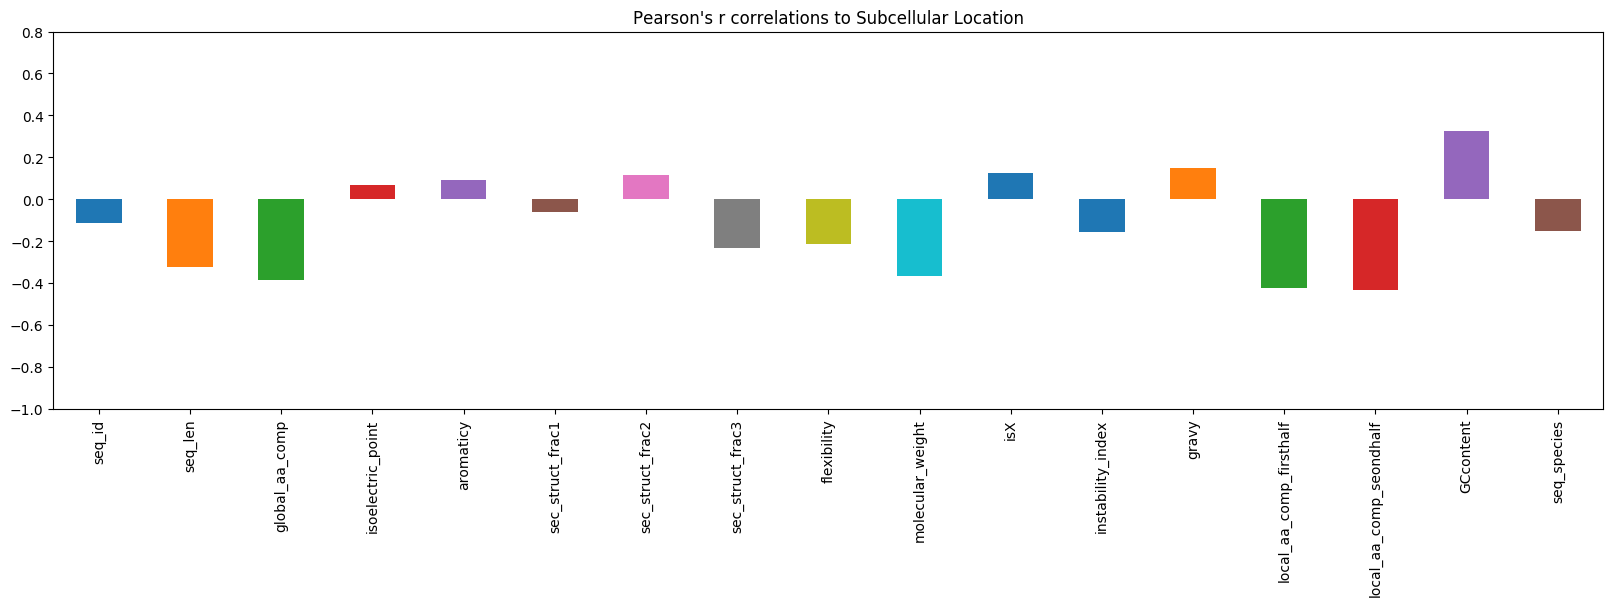

In [51]:
# Here we create an array of correlations between each feature in X, and y (the FTR data).
pears_r = []
for columns in X:
    inData = sp.stats.pearsonr(X[columns], y)
    pears_r.append(inData[0])

# Draw a bar chart to visualise the correlations
pears_df = pd.Series(pears_r, index = X.columns)
pears_df.plot.bar(figsize=(20,5), 
                  yticks=np.arange(-1,1, 0.2), 
                  title = "Pearson's r correlations to Subcellular Location")

In [52]:
sequence_data.index[sequence_data['subcellular_location'] == 0].tolist()

[1605,
 1606,
 1607,
 1608,
 1609,
 1610,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1624,
 1625,
 1626,
 1627,
 1628,
 1629,
 1630,
 1631,
 1632,
 1633,
 1634,
 1635,
 1636,
 1637,
 1638,
 1639,
 1640,
 1641,
 1642,
 1643,
 1644,
 1645,
 1646,
 1647,
 1648,
 1649,
 1650,
 1651,
 1652,
 1653,
 1654,
 1655,
 1656,
 1657,
 1658,
 1659,
 1660,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1667,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 1676,
 1677,
 1678,
 1679,
 1680,
 1681,
 1682,
 1683,
 1684,
 1685,
 1686,
 1687,
 1688,
 1689,
 1690,
 1691,
 1692,
 1693,
 1694,
 1695,
 1696,
 1697,
 1698,
 1699,
 1700,
 1701,
 1702,
 1703,
 1704,
 1705,
 1706,
 1707,
 1708,
 1709,
 1710,
 1711,
 1712,
 1713,
 1714,
 1715,
 1716,
 1717,
 1718,
 1719,
 1720,
 1721,
 1722,
 1723,
 1724,
 1725,
 1726,
 1727,
 1728,
 1729,
 1730,
 1731,
 1732,
 1733,
 1734,
 1735,
 1736,
 1737,
 1738,
 1739,
 1740,
 1741,
 1742,
 1743,
 1744,
 1745,
 1746,
 1747,

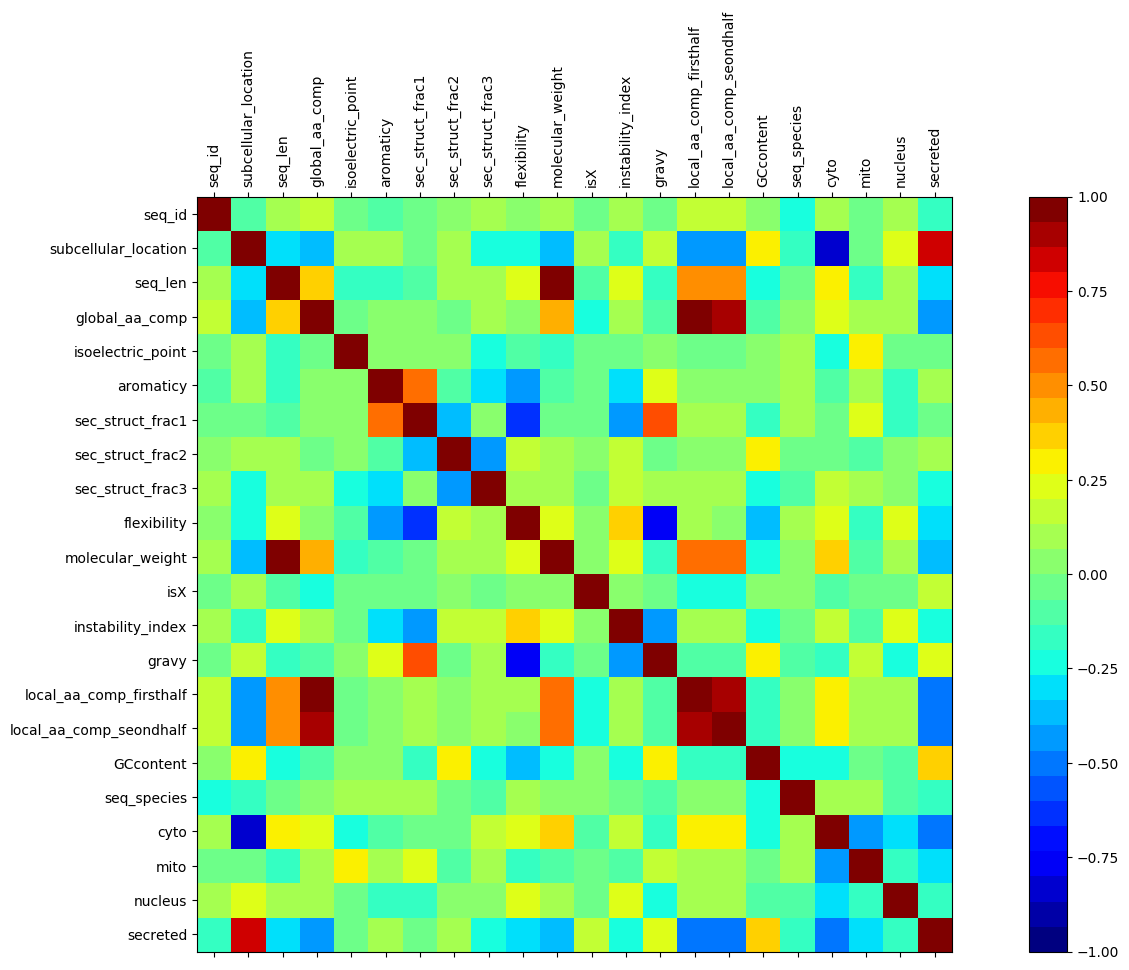

In [53]:
extra_seq_data = sequence_data.copy()

loc = extra_seq_data.index[sequence_data['subcellular_location'] == 0].tolist()
ok = np.zeros(len(extra_seq_data))
ok[min(loc):max(loc)] = 1
extra_seq_data['cyto'] = pd.Series(ok)

loc = extra_seq_data.index[sequence_data['subcellular_location'] == 1].tolist()
ok = np.zeros(len(extra_seq_data))
ok[min(loc):max(loc)] = 1
extra_seq_data['mito'] = ok
    
loc = extra_seq_data.index[sequence_data['subcellular_location'] == 2].tolist()
ok = np.zeros(len(extra_seq_data))
ok[min(loc):max(loc)] = 1
extra_seq_data['nucleus'] = ok
    
loc = extra_seq_data.index[sequence_data['subcellular_location'] == 3].tolist()
ok = np.zeros(len(extra_seq_data))
ok[min(loc):max(loc)] = 1
extra_seq_data['secreted'] = ok
    
    
correlations = extra_seq_data.corr()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax.matshow(correlations, interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.grid(False)

fig.colorbar(cax)
ticks = np.arange(len(extra_seq_data.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(extra_seq_data.columns)
ax.set_yticklabels(extra_seq_data.columns)
plt.show()

/Users/nathalievonhuth/.virtualenvs/nlp_test_env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


,Feature Importance,RFE,Stability
flexibility,0.65,1.00,0.97
isX,0.00,1.00,0.49
isoelectric_point,1.00,1.00,0.00
local_aa_comp_seondhalf,0.68,1.00,0.84
sec_struct_frac1,0.54,1.00,0.45
sec_struct_frac3,0.63,0.92,1.00
local_aa_comp_firsthalf,0.41,0.83,0.59
...,...,...,...
molecular_weight,0.61,0.50,0.73
instability_index,0.54,0.42,0.29


None

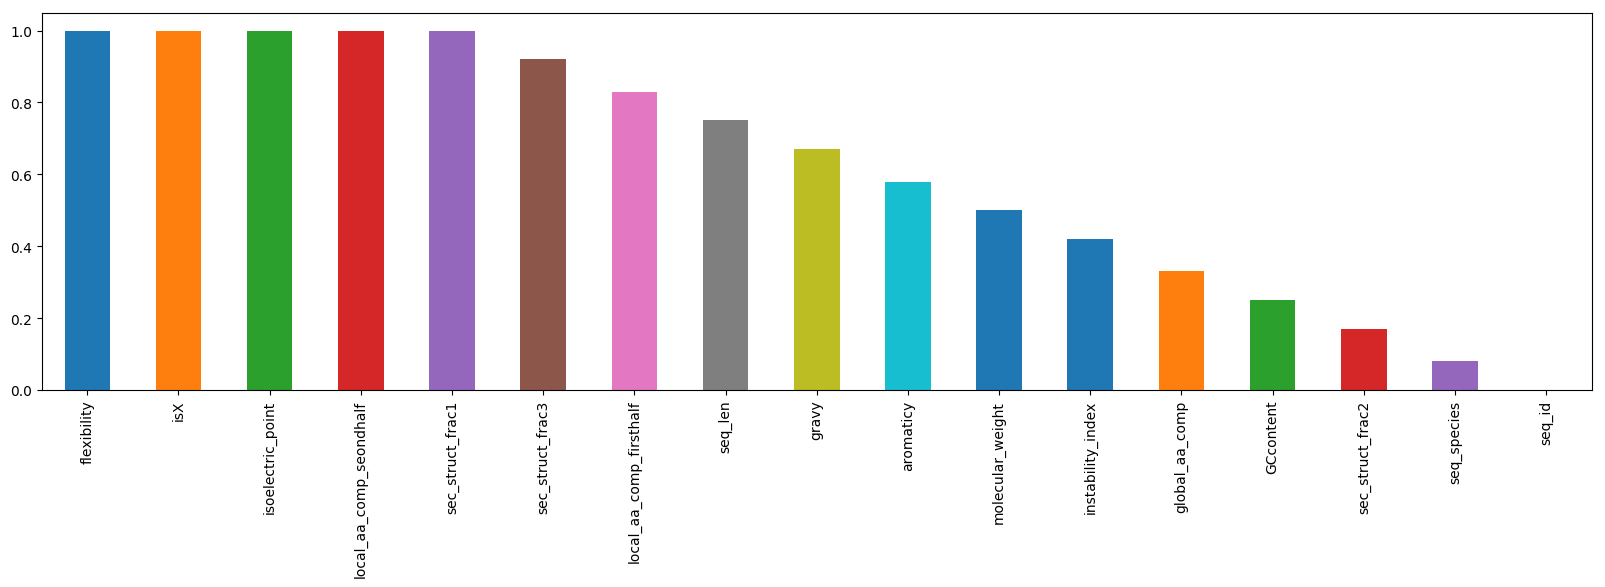

In [54]:
names = X.columns
ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

# Find stability of feature
def stability(ranks, name):
    rlasso = RandomizedLasso(alpha = 0.0005)
    rlasso.fit(X, y)
    ranks[name] = rank_to_dict(np.abs(rlasso.scores_), names)

# Find the RFE of feature and find top 5 features
def rfe(ranks, name):
    lr = LogisticRegression()
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X, y)
    ranks[name] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)

# Find the importance of the feature
def feat_imp(ranks, name):
    forest = ExtraTreesClassifier()
    forest.fit(X, y)
    ranks[name] = rank_to_dict(map(float, forest.feature_importances_), names)

stability(ranks, "Stability")
rfe(ranks, "RFE")
feat_imp(ranks, "Feature Importance")

f, pval  = f_regression(X, y, center=True)
ranks = pd.DataFrame(ranks)
ranks = ranks.sort_values(['RFE'], ascending = False)

display(ranks, pd.set_option('display.max_rows', 15))

# Draw graph showing the Randomized Lasso 
ranks['RFE'].plot(kind='bar', figsize=(20,5))

In [55]:
# Remove all irrelevant features
X = X.copy()
for rank in ranks.index:
    if ranks['RFE'][rank] < 0.3:
        X.drop(rank, axis=1, inplace=True)

## Cross validate the data

In [56]:
X.shape

(6650, 13)

In [57]:
y.shape

(6650,)

In [58]:
y_bin = label_binarize(y, classes=[0,1,2,3])
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC_y'])

In [59]:
y_bin

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [87]:
from imblearn.ensemble import BalancedBaggingClassifier 
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
bbc = BalancedBaggingClassifier(random_state=42)
bbc_proba = cross_val_predict(bbc, X, y, cv = KFold(n_splits = 3), method='predict_proba')
bbc_score = cross_val_score(bbc, X,y,cv=3)
bbc_auc_y = roc_auc_score(y_bin, bbc_proba)

results = results.append(pd.DataFrame({"Model": "BBC", "Accuracy": bbc_score.mean(),"AUC_y": bbc_auc_y}, index=[0]))
# bbc.fit(X_train, y_train)
# y_pred = bbc.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

In [55]:
# Supper Vector Classifier
svc = SVC(kernel='rbf', C=1.0, probability=1)
svc_proba = cross_val_predict(svc, X, y, cv = KFold(n_splits = 3), method='predict_proba')
svc_score = cross_val_score(svc, X, y, cv=3)
svc_auc_y = roc_auc_score(y_bin, svc_proba)

results = results.append(pd.DataFrame({"Model": "SVC", "Accuracy": svc_score.mean(),"AUC_y": svc_auc_y}, index=[0]))

In [88]:
# Gaussian Naive Bayes Model
gnb = GaussianNB()
gnb_proba = cross_val_predict(gnb, X, y, cv = KFold(n_splits = 3), method='predict_proba')
gnb_score = cross_val_score(gnb, X, y, cv=3)
gnb_auc_y = roc_auc_score(y_bin, gnb_proba)

results = results.append(pd.DataFrame({"Model": "GNB", "Accuracy": gnb_score.mean(),"AUC_y": gnb_auc_y}, index=[0]))

In [89]:
# Ada Boost Classifier
ada = AdaBoostClassifier(n_estimators=100)
ada_proba = cross_val_predict(ada, X, y, cv = KFold(n_splits = 3), method='predict_proba')
ada_score = cross_val_score(ada, X, y, cv=3)
ada_auc_y = roc_auc_score(y_bin, ada_proba)

results = results.append(pd.DataFrame({"Model": "Ada Boost", "Accuracy": ada_score.mean(),"AUC_y": ada_auc_y}, index=[0]))

In [90]:
# In the KNN classifier we train on different neighbour values to get the n with the highest performance rate
knn_auc = 0
best_n = 0
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn_proba = cross_val_predict(knn, X, y, cv = KFold(n_splits = 3), method = 'predict_proba')
    if(roc_auc_score(y_bin, knn_proba) > knn_auc):
        knn_auc = roc_auc_score(y_bin, knn_proba)
        best_n = i

knn = KNeighborsClassifier(n_neighbors=best_n)
knn_proba = cross_val_predict(knn, X, y, cv = KFold(n_splits = 3), method = 'predict_proba')
knn_score = cross_val_score(knn, X, y, cv=3)
knn_auc_y = roc_auc_score(y_bin, knn_proba)

results = results.append(pd.DataFrame({"Model": "KNN", "Accuracy": knn_score.mean(),"AUC_y": knn_auc_y}, index=[0]))

In [91]:
# Logistic Regression Model
log = LogisticRegression()
log_proba = cross_val_predict(log, X, y, cv=KFold(n_splits=3), method='predict_proba')
log_score = cross_val_score(log, X, y, cv=3)
log_auc_y = roc_auc_score(y_bin, log_proba)

results = results.append(pd.DataFrame({"Model": "Logistic Regression", "Accuracy": log_score.mean(),"AUC_y": log_auc_y}, index=[0]))

In [60]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 4), random_state=1)
mlp_proba = cross_val_predict(mlp, X, y, cv=KFold(n_splits=3), method='predict_proba')
mlp_score = cross_val_score(mlp, X, y, cv=3)
mlp_auc_y = roc_auc_score(y_bin, mlp_proba)

results = results.append(pd.DataFrame({"Model": "MLP", "Accuracy": mlp_score.mean(),"AUC_y": mlp_auc_y}, index=[0]))

      AUC_y  Accuracy                Model
0  0.454998  0.565712                  SVC
0  0.431083  0.318894                  GNB
0  0.438625  0.608271            Ada Boost
0  0.444684  0.621049                  KNN
0  0.438625  0.639549  Logistic Regression
0  0.438625  0.645261                  MLP


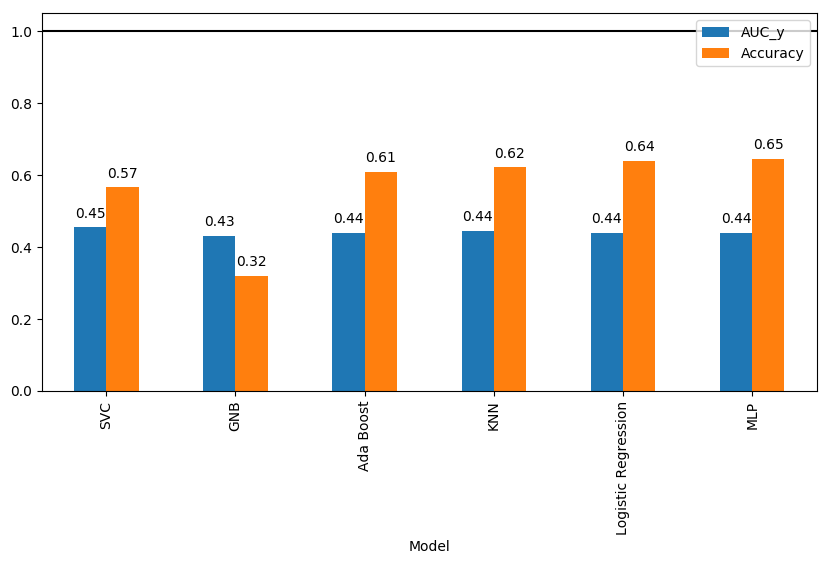

In [120]:
# results.set_index('Model', inplace=True)
print results
ax = results.ix[0].plot(x="Model", kind='bar', figsize=(10,5)); plt.axhline(1, color='k')

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [64]:
knn.fit(X, y)

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
knn_cv = cross_val_score(knn, X, y)
knn_pred = cross_val_predict(knn, X, y, cv=3)
knn_auc_y = roc_auc_score(y_bin, knn_proba)

print "Cross val score: %.3f" % np.mean(knn_cv)
print "AUC score: %.3f" % knn_auc_y
print classification_report(y, knn_pred)

Cross val score: 0.621
AUC score: 0.445
             precision    recall  f1-score   support

          0       0.61      0.82      0.70      3004
          1       0.55      0.53      0.54      1299
          2       0.31      0.08      0.13       742
          3       0.81      0.56      0.66      1605

avg / total       0.61      0.62      0.60      6650



In [61]:
mlp = MLPClassifier(solver='adam', 
                    activation='logistic', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(100, 10), 
                    random_state=1, 
                    shuffle=False,
                    warm_start=True
                   )
mlp.fit(X, y)

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
mlp_cv = cross_val_score(mlp, X, y)
mlp_pred = cross_val_predict(mlp, X, y, cv=3)
mlp_auc_y = roc_auc_score(y_bin, mlp_proba)

print "Cross val score: %.3f" % np.mean(mlp_cv)
print "AUC score: %.3f" % mlp_auc_y
print classification_report(y, mlp_pred)

Cross val score: 0.652
AUC score: 0.439
             precision    recall  f1-score   support

          0       0.64      0.83      0.72      3004
          1       0.58      0.56      0.57      1299
          2       0.41      0.01      0.02       742
          3       0.76      0.69      0.72      1605

avg / total       0.63      0.65      0.61      6650



/Users/nathalievonhuth/.virtualenvs/nlp_test_env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Normalized confusion matrix
[[0.83 0.1  0.   0.07]
 [0.34 0.56 0.   0.09]
 [0.85 0.1  0.01 0.04]
 [0.22 0.1  0.   0.69]]


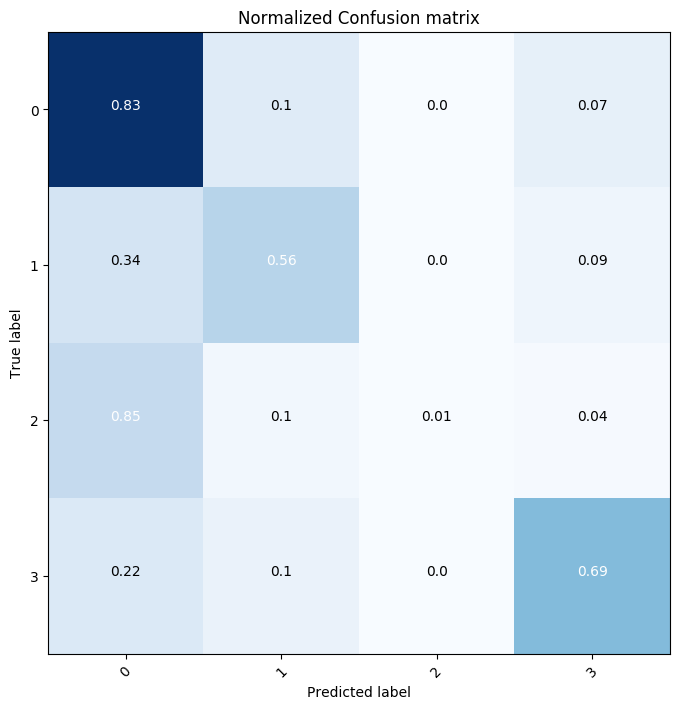

In [67]:
# Confusion Matrix from sklearn's demo
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals = 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix =  confusion_matrix(y, mlp_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=d['subcellular_location'].inverse_transform([0, 1, 2, 3]), normalize=True, title='Normalized Confusion matrix')
plt.show()

## Classifying the final set

In [135]:
d_test = defaultdict(preprocessing.LabelEncoder)
X_test = addSubcellularData('blind')
X_test_clean, d_test = clean_data(X_test, d_test)

In [136]:
X_test_clean = X_test_clean.copy()
for rank in ranks.index:
    if ranks['RFE'][rank] < 0.4:
        X_test_clean.drop(rank, axis=1, inplace=True)

In [162]:
mlp_test_pred = mlp.predict(X_test_clean)
mlp_test_proba = mlp.predict_proba(X_test_clean)

In [179]:
mlp_test_proba[0]

array([0.81, 0.04, 0.13, 0.01])

In [145]:
d_test['seq_id'].classes_

array(['SEQ122', 'SEQ173', 'SEQ202', 'SEQ224', 'SEQ231', 'SEQ322',
       'SEQ333', 'SEQ351', 'SEQ388', 'SEQ402', 'SEQ433', 'SEQ608',
       'SEQ677', 'SEQ758', 'SEQ821', 'SEQ862', 'SEQ871', 'SEQ937',
       'SEQ951', 'SEQ982'], dtype=object)

In [190]:
dtest = X_test.copy()
dtest['subcellular_location'] = mlp_test_pred
conf_series = pd.Series()

for i, res in enumerate(dtest['subcellular_location']):
    conf_series.loc[i] = mlp_test_proba[i][res]

    
dtest = dtest[['subcellular_location']].apply(lambda x: d_seq['subcellular_location'].inverse_transform(x))
dtest['seq_id'] = X_test['seq_id']
conf_series.index = dtest.index
dtest.loc[:,'confidence'] = conf_series
dtest = dtest.reset_index()

with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    display(dtest[['seq_id', 'subcellular_location', 'confidence']])

0    0.808919
0    0.588116
0    0.578826
0    0.414391
0    0.554669
0    0.634001
0    0.693367
       ...   
0    0.753130
0    0.520707
0    0.957707
0    0.487392
0    0.659661
0    0.558163
0    0.680986
Length: 20, dtype: float64


/Users/nathalievonhuth/.virtualenvs/nlp_test_env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/nathalievonhuth/.virtualenvs/nlp_test_env/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,seq_id,subcellular_location,confidence
0,SEQ677,cyto,0.808919
1,SEQ231,cyto,0.588116
2,SEQ871,secreted,0.578826
3,SEQ388,mito,0.414391
4,SEQ122,cyto,0.554669
5,SEQ758,cyto,0.634001
6,SEQ333,mito,0.693367
7,SEQ937,cyto,0.793711
8,SEQ351,cyto,0.449568
9,SEQ202,secreted,0.792470


In [182]:
dtest

,index,subcellular_location,seq_id,confidence
0,0,cyto,SEQ677,0.808919
1,0,cyto,SEQ231,0.808919
2,0,secreted,SEQ871,0.808919
3,0,mito,SEQ388,0.808919
4,0,cyto,SEQ122,0.808919
5,0,cyto,SEQ758,0.808919
6,0,mito,SEQ333,0.808919
...,...,...,...,...
13,0,cyto,SEQ821,0.808919
14,0,cyto,SEQ322,0.808919
